In [1]:
import numpy as np
import pandas as pd
import os 
import torch.utils.data as data
import keras
from keras import models
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D
from keras.preprocessing import image
from numpy import array
from keras import metrics
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
base_skin_dir = os.path.join('', 'dataset')

Using TensorFlow backend.


In [3]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [5]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes

In [38]:
tile_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [6]:
data = []
IMAGE_DIMS = (100, 75, 3)
def load_img_with_cv2(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    return image

for img_path in tile_df['path']:
    data.append(load_img_with_cv2(img_path))

In [7]:
data = np.array(data, dtype='float') / 255.0
labels = np.array(tile_df['dx'])
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42)

In [25]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [28]:
precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)


# Определим топологию нейронной сети 

In [29]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(100,75, 3), padding='SAME'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(7, activation = 'softmax'))
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
                metrics=[ precision,recall]
)

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 75, 32)       896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 37, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 35, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 17, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 11, 7, 128)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9856)              0         
__________

# Обучим нейронную сеть 



In [31]:
history = model.fit(X_train, y_train, epochs=30, batch_size=128 )

Epoch 1/30
8012/8012 [==============================] - 38s 5ms/step - loss: 1.0579 - precision: 0.1406 - recall: 0.9840
Epoch 2/30
8012/8012 [==============================] - 6s 743us/step - loss: 0.8779 - precision: 0.1429 - recall: 1.0000
Epoch 3/30
8012/8012 [==============================] - 6s 736us/step - loss: 0.8111 - precision: 0.1429 - recall: 1.0000
Epoch 4/30
8012/8012 [==============================] - 6s 739us/step - loss: 0.7611 - precision: 0.1429 - recall: 1.0000
Epoch 5/30
8012/8012 [==============================] - 6s 739us/step - loss: 0.6989 - precision: 0.1429 - recall: 1.0000
Epoch 6/30
8012/8012 [==============================] - 6s 773us/step - loss: 0.6795 - precision: 0.1429 - recall: 1.0000
Epoch 7/30
8012/8012 [==============================] - 6s 747us/step - loss: 0.6425 - precision: 0.1429 - recall: 1.0000
Epoch 8/30
8012/8012 [==============================] - 6s 747us/step - loss: 0.6377 - precision: 0.1429 - recall: 1.0000
Epoch 9/30
8012/8012 [===

# Построим графики результатов обучения нейронной сети 


In [32]:
print(history.history.keys())

dict_keys(['loss', 'precision', 'recall'])


In [22]:
print(history.history['categorical_accuracy'])

[0.6635047426178523, 0.6917124310851513, 0.7158012981421937, 0.7386420367362794, 0.7477533696772632, 0.756739889956449, 0.7656015978714138, 0.775836245512522, 0.7976784822468275, 0.8020469294865609, 0.8092860711614787, 0.8258861708033995, 0.8316275585429762, 0.8422366450026937, 0.8463554669485888, 0.8655766350771865, 0.8743135299435033, 0.87805791318982, 0.8911632549685355, 0.8960309537779493, 0.913130304751489, 0.9239890162074679, 0.9302296557250287, 0.9279830256998688, 0.9422116825953163, 0.9543185224249788, 0.9573140286887459, 0.9658012982612244, 0.956315526531389, 0.9580629055522646]


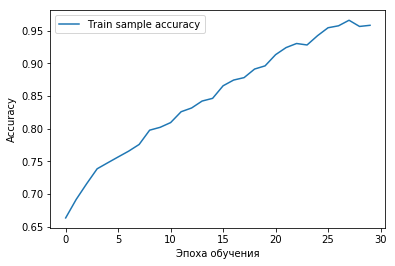

In [23]:
plt.plot(history.history['categorical_accuracy'], label='Train sample accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Проверим полученную модель на тестовой выборке 

In [33]:
score = model.evaluate(X_test, y_test, batch_size=128)
score

2003/2003 [==============================] - 2s 984us/step


[1.40058215302464, 0.14291473564748103, 1.0]

# Выгрузим промежуточные изображения из слоёв нейронной сети 

In [15]:
activation_model = models.Model(inputs=model.input, outputs=model.layers[2].output)
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 100, 75, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 75, 32)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 35, 64)        18496     
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________


In [65]:
activation = activation_model.predict(X_test)
images_per_row = 16
n_filters = activation.shape[-1]
size = activation.shape[1]
n_cols = n_filters // images_per_row
display_grid = np.zeros((n_cols * size, images_per_row * size))

for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = activation[0, :, :, col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size0 : (row + 1) * size0] = channel_image
        
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

(2003, 48, 35, 64)


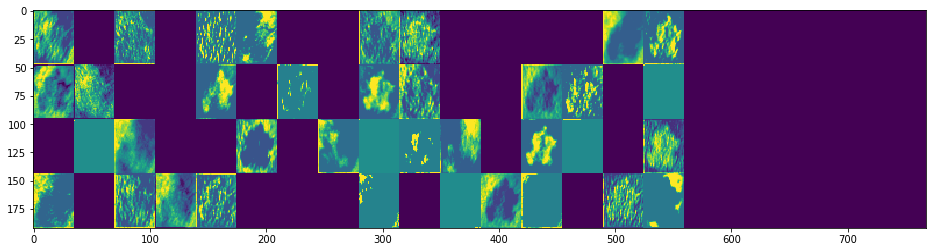

In [83]:
plt.imshow(display_grid, aspect='auto', cmap='viridis')